
# ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [1]:
# Parameters
SEQ_LEN = 24  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
EPOCHS = 30 
BATCH_SIZE = 32

# VMD parameters
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from vmdpy import VMD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
save_dir = os.path.expanduser("~/Project/AttnLstm/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


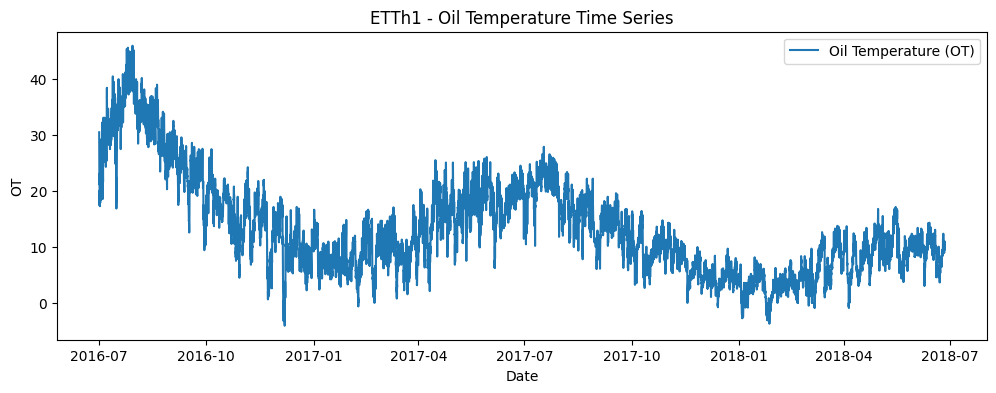

In [4]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split Simple

In [25]:
# =====================================================
# Split Train/Test
# =====================================================
split_idx = int(len(df) * 0.8)
train_data = df[:split_idx]
test_data  = df[split_idx:]
# =====================================================
# Helper for VMD-based training data
# =====================================================
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    limit = min(len(X), len(y)) - seq_len
    for i in range(limit):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

def create_sequences2(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len, 0])
    return np.array(X), np.array(y)
    
def train_test(alpha=1, tau=1, K=1):
    # --- VMD on train and test ---
    u_train, _, _ = VMD(train_data[TARGET_COL].values, alpha, tau, K, DC=0, init=1, tol=1e-7)
    u_test,  _, _ = VMD(test_data[TARGET_COL].values,  alpha, tau, K, DC=0, init=1, tol=1e-7)

    vmd_train = np.stack(u_train, axis=1)
    vmd_test  = np.stack(u_test,  axis=1)

    # --- Scale features & target ---
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled_vmd = scaler_x.fit_transform(vmd_train)
    y_train_scaled = scaler_y.fit_transform(train_data[[TARGET_COL]])
    X_test_scaled_vmd  = scaler_x.transform(vmd_test)
    y_test_scaled  = scaler_y.transform(test_data[[TARGET_COL]])

    # --- Sequence generation (aligned) ---
    X_train_vmd_seq, y_train_vmd_seq = create_sequences(X_train_scaled_vmd, y_train_scaled, SEQ_LEN)
    X_test_vmd_seq,  y_test_vmd_seq  = create_sequences(X_test_scaled_vmd,  y_test_scaled,  SEQ_LEN)
    X_train_simple_seq, y_train_simple_seq = create_sequences2(y_train_scaled,SEQ_LEN)
    X_test_simple_seq, y_test_simple_seq = create_sequences2(y_test_scaled,SEQ_LEN)

    # ✅ Align lengths with simple test (optional for comparison)
    min_len = min(len(y_test_vmd_seq), len(y_test_simple_seq))
    y_test_vmd_seq = y_test_vmd_seq[-min_len:]
    y_test_simple_seq = y_test_simple_seq[-min_len:]
    X_test_vmd_seq = X_test_vmd_seq[-min_len:]

    return scaler_y,X_train_vmd_seq, y_train_vmd_seq, X_test_vmd_seq, y_test_vmd_seq,X_train_simple_seq,y_train_simple_seq,X_test_simple_seq,y_test_simple_seq


# AttnLSTM+vmd+GA
    - VMD parameters (like alpha, K, tau, etc.)

    - Model parameters (like number of LSTM units, learning rate, dropout, etc.)

We’ll use a Genetic Algorithm (GA) for joint optimization of both sets.

#### Why this architecture?

- The **stacked LSTM layers** capture hierarchical temporal‑dependencies within the input sequence.  
- The **Attention() layer** allows the model to dynamically focus on different time‑steps of the sequence (via self‑attention over the LSTM outputs).  
- By extracting both the **last output** and the **mean of the attention context**, the model combines both “summary” information and distributed attention information.  
- This **hybrid structure (LSTM + Attention)** is especially useful in non‑stationary, complex time series where long‑range dependencies and varying importance of past steps matter.

---

#### Relevant Literature (JCR / peer‑reviewed journals)

Here are some notable papers that use attention mechanisms with LSTM (or RNN) for time‑series forecasting:

1. **Xu, Y., …** “Potential Analysis of the Attention‑Based LSTM Model in HVAC Energy Consumption Prediction”, *Frontiers in Energy Research* (2021).  
   - This paper applies an attention‑LSTM (“A‑LSTM”) to hourly HVAC load forecasting.  
   - [Frontiers link](https://www.frontiersin.org/journals/energy-research/articles/10.3389/fenrg.2021.730640/full)

2. **Wu, P., …** “A Combined Deep Learning Method with Attention‑Based LSTM (ATT‑LSTM) for Short‑Term Traffic Speed Prediction”, [journal] (2020).  
   - Uses attention + LSTM for traffic forecasting.  
   - [Wiley Online Library link](https://onlinelibrary.wiley.com/doi/10.1155/2020/8863724)

3. **Zhou, S., Guo, S., Du, B., Huang, S., Guo, J.** “A Hybrid Framework for Multivariate Time Series Forecasting of Daily Urban Water Demand Using Attention‑Based CNN‑LSTM”, *Sustainability, 14(17), 11086* (2022).  
   - Although this uses CNN+LSTM+Attention, it demonstrates the effective use of attention in LSTM‑based forecasting.  
   - [MDPI link](https://www.mdpi.com/2071-1050/14/17/11086)

4. **Kumar, I., …** “Attention‑based LSTM Network‑Assisted Time Series Forecasting of Production Data”, [journal] (2023).  
   - Direct “attention‑LSTM” application in a real industrial forecasting setting.  
   - [ScienceDirect link](https://www.sciencedirect.com/science/article/abs/pii/S0952197623006243)



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from vmdpy import VMD
import random

# =====================================================
# 1️⃣ Global Config
# =====================================================
SEQ_LEN = SEQ_LEN        # sequence length
EPOCHS_OPT = 4           # epochs during GA fitness
EPOCHS_FINAL = EPOCHS    # final retraining

# =====================================================
# 2️⃣ ATT-LSTM Model Builder
# =====================================================
def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32):
    inp = Input(shape=input_shape)
    lstm_out = LSTM(lstm1_units, return_sequences=True)(inp)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention
    query = Dense(lstm1_units)(lstm_out)
    value = Dense(lstm1_units)(lstm_out)
    attention_out = Attention()([query, value])
    attention_out = Concatenate()([lstm_out, attention_out])

    # Decoder
    lstm_dec = LSTM(lstm2_units, return_sequences=False)(attention_out)
    dense_out = Dense(dense_units, activation='relu')(lstm_dec)
    final_out = Dense(1)(dense_out)

    model = Model(inputs=inp, outputs=final_out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    return model

# =====================================================
# 4️⃣ Fitness Function (GA objective)
# =====================================================
def fitness(params, data):
    alpha, tau, K = params['alpha'], params['tau'], params['K']
    lstm1_units, lstm2_units, dense_units = (
        params['lstm1_units'], params['lstm2_units'], params['dense_units']
    )
    
    _,X_train_vmd_seq, y_train_vmd_seq, X_test_vmd_seq, y_test_vmd_seq,_,_,_,_= train_test(alpha, tau, K)
    
    # --- Model ---
    model = build_attlstm_model(
        (SEQ_LEN, K),
        lstm1_units=lstm1_units,
        lstm2_units=lstm2_units,
        dense_units=dense_units
    )

    history = model.fit(
        X_train_vmd_seq, y_train_vmd_seq,
        validation_data=(X_test_vmd_seq, y_test_vmd_seq),
        epochs=EPOCHS_OPT,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    mse = min(history.history['val_loss'])
    return mse

# =====================================================
# 5️⃣ Genetic Algorithm (GA)
# =====================================================
def random_params():
    return {
        'alpha': random.uniform(500, 3000),
        'tau': random.uniform(0.0, 0.5),
        'K': random.randint(3, 8),
        'lstm1_units': random.choice([64, 96, 128, 160]),
        'lstm2_units': random.choice([32, 48, 64, 96]),
        'dense_units': random.choice([16, 32, 48, 64])
    }

def mutate(params):
    new_params = params.copy()
    if random.random() < 0.4:
        new_params['alpha'] *= random.uniform(0.8, 1.2)
    if random.random() < 0.4:
        new_params['tau'] += random.uniform(-0.05, 0.05)
    if random.random() < 0.3:
        new_params['K'] = max(2, min(10, new_params['K'] + random.choice([-1, 1])))
    if random.random() < 0.4:
        new_params['lstm1_units'] = random.choice([64, 96, 128, 160])
    if random.random() < 0.4:
        new_params['lstm2_units'] = random.choice([32, 48, 64, 96])
    if random.random() < 0.4:
        new_params['dense_units'] = random.choice([16, 32, 48, 64])
    return new_params

def evolve_population(data, pop_size=4, generations=3):
    population = [random_params() for _ in range(pop_size)]
    for g in range(generations):
        print(f"\n🧬 Generation {g+1}/{generations}")
        scores = []
        for i, params in enumerate(population):
            mse = fitness(params, data)
            scores.append((mse, params))
            print(f"  Candidate {i+1}: MSE = {mse:.4f}, params = {params}")
        scores.sort(key=lambda x: x[0])
        best_params = scores[0][1]
        print(f"  ✅ Best so far: {best_params}")
        # Evolve
        new_pop = [scores[0][1], scores[1][1]]
        while len(new_pop) < pop_size:
            parent = random.choice(new_pop)
            new_pop.append(mutate(parent))
        population = new_pop
    return best_params

# =====================================================
# 6️⃣ Run Optimization
# =====================================================
best_params = evolve_population(df, pop_size=4, generations=3)
print("\n🏁 Best parameters found:", best_params)

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 24, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_66 (LSTM)      │ (None, 24, 96)    │     38,784 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 24, 96)    │          0 │ lstm_66[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_114 (Dense)   │ (None, 24, 96)    │      9,312 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_115 (Dense)   │ (None, 24, 96)    │      9,312 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_27        │ (None, 24, 96)    │          0 │ dense_114[0][0],  │
│ (Attention)         │                   │            │ dense_115[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 24, 192)   │          0 │ dropout_36[0][0], │
│ (Concatenate)       │                   │            │ attention_27[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_67 (LSTM)      │ (None, 64)        │     65,792 │ concatenate_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_116 (Dense)   │ (None, 32)        │      2,080 │ lstm_67[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_117 (Dense)   │ (None, 1)         │         33 │ dense_116[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,313 (489.50 KB)

 Trainable params: 125,313 (489.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0082 - mae: 0.0504 - val_loss: 2.5755e-04 - val_mae: 0.0120
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 5.9321e-04 - mae: 0.0186 - val_loss: 1.4195e-04 - val_mae: 0.0088
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3.7203e-04 - mae: 0.0146 - val_loss: 1.0585e-04 - val_mae: 0.0078
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 2.7818e-04 - mae: 0.0126 - val_loss: 8.5441e-05 - val_mae: 0.0070
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.5945e-04 - mae: 0.0123 - val_loss: 1.2334e-04 - val_mae: 0.0090
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 2.0779e-04 - mae: 0.0110 - val_loss: 5.7751e-05 - val_mae: 0.0057
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 2.1318e-04 - mae: 0.0111 - val_loss: 5.5964e-05 - val_mae: 0.0056
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.6853e-04 - mae: 0.0097 - val_loss: 5.1399e-05 - val_

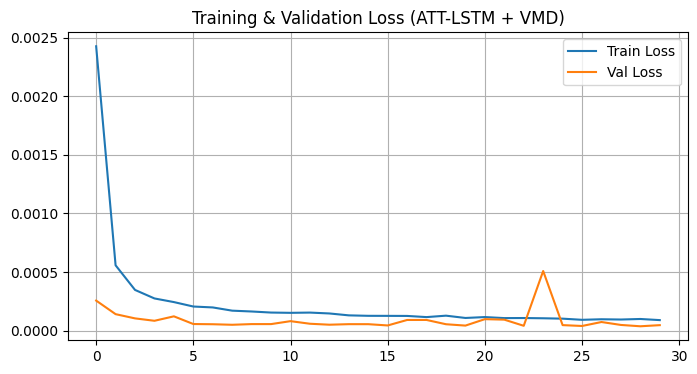

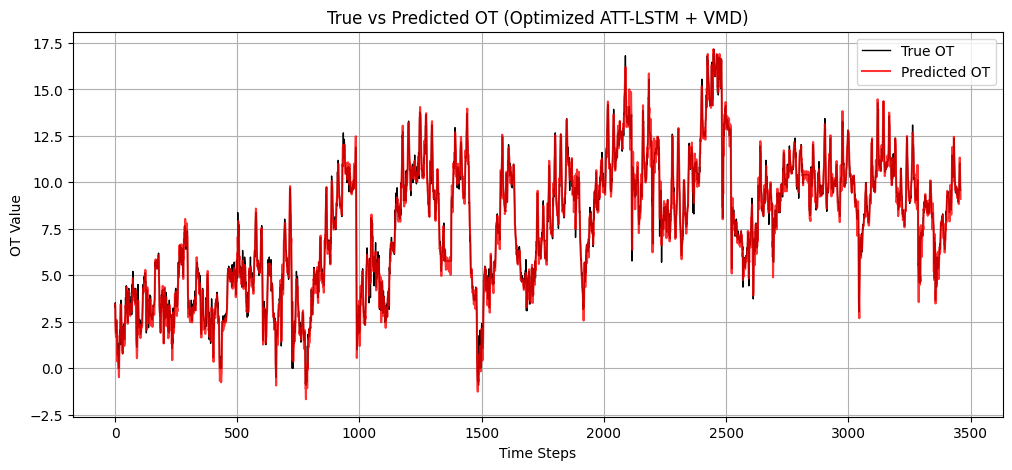

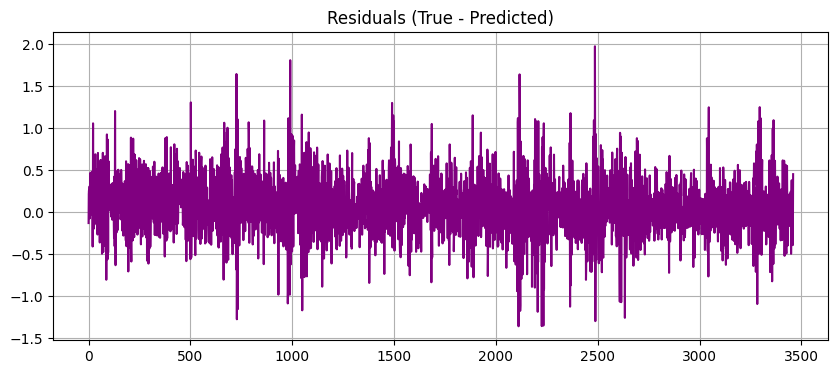

In [38]:
# =====================================================
# 7️⃣ Retrain with Best Params (no leakage)
# =====================================================
alpha, tau, K = best_params['alpha'], best_params['tau'], best_params['K']
lstm1_units, lstm2_units, dense_units = (
    best_params['lstm1_units'], best_params['lstm2_units'], best_params['dense_units']
)

scaler_y,X_train_vmd_seq, y_train_vmd_seq, X_test_vmd_seq, y_test_vmd_seq,_,_,_,_= train_test(alpha, tau, K) 


model = build_attlstm_model((SEQ_LEN, K), lstm1_units, lstm2_units, dense_units)
model.summary()

history = model.fit(
    X_train_vmd_seq, y_train_vmd_seq,
    validation_data=(X_test_vmd_seq, y_test_vmd_seq),
    epochs=EPOCHS_FINAL,
    batch_size=32,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_scaled = model.predict(X_test_vmd_seq)
y_pred_attlstm_true = scaler_y.inverse_transform(y_pred_scaled)
y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd_seq)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_attlstm_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

## LSTM+simple

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 24, 244)        │       121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 24, 244)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 24, 122)        │       179,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 24, 64)         │        47,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 122)            │        91,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 32)             │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,217 (1.69 MB)

 Trainable params: 443,217 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0092 - val_loss: 8.4108e-04
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0016 - val_loss: 4.4406e-04
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - val_loss: 5.9505e-04
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.8913e-04 - val_loss: 2.5687e-04
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.0650e-04 - val_loss: 2.3948e-04
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.3211e-04 - val_loss: 2.7973e-04
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 7.2424e-04 - val_loss: 2.5469e-04
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.0800e-04 - val_loss: 2.6640e-04
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.8641e-04 - val_loss: 4.0538e-04
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.0145e-04 - val_loss: 2.1341e-04
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.9727

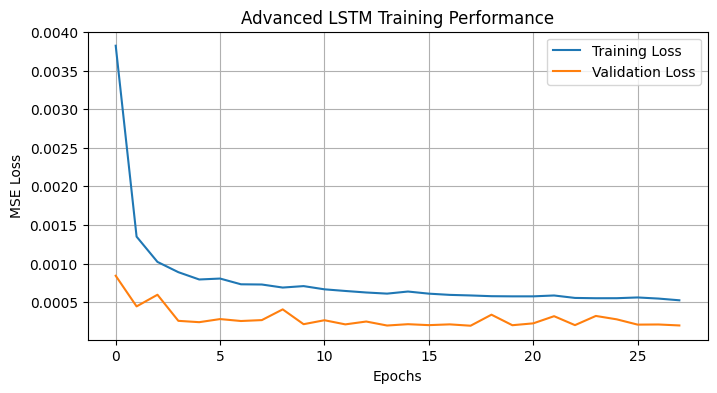

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


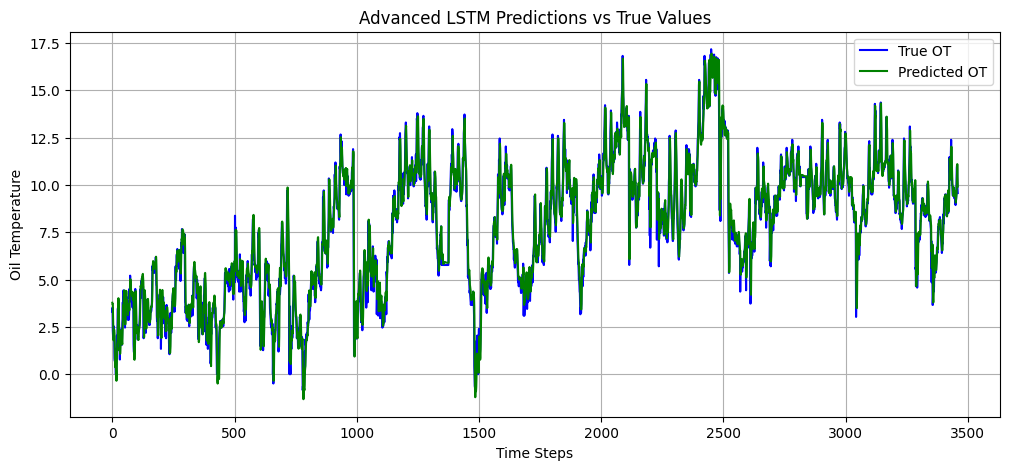

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

scaler_y,_,_,_,_,X_train_simple_seq,y_train_simple_seq,X_test_simple_seq,y_test_simple_seq = train_test() 

# Advanced LSTM model
advanced_lstm = Sequential([
    Bidirectional(LSTM(122, return_sequences=True), input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(122, return_sequences=True),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(122, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

advanced_lstm.compile(optimizer='adam', loss='mse')
advanced_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_adv = advanced_lstm.fit(
    X_train_simple_seq, y_train_simple_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple_seq, y_test_simple_seq),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_adv.history['loss'], label='Training Loss')
plt.plot(history_adv.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Advanced LSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_scaled_lstm = advanced_lstm.predict(X_test_simple_seq)
y_pred_lstm_true = scaler_y.inverse_transform(y_pred_scaled_lstm.reshape(-1, 1)).flatten()
y_test_simple_true = scaler_y.inverse_transform(y_test_simple_seq.reshape(-1, 1)).flatten()


# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_lstm_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()


## compare lstm_simple and attlstm_vmd_ga

📈 Model Performance Comparison
ATT-LSTM (VMD): MSE=0.1209, RMSE=0.3476, MAE=0.2628, R²=0.9902
Advanced BiLSTM: MSE=0.4856, RMSE=0.6968, MAE=0.4826, R²=0.9578


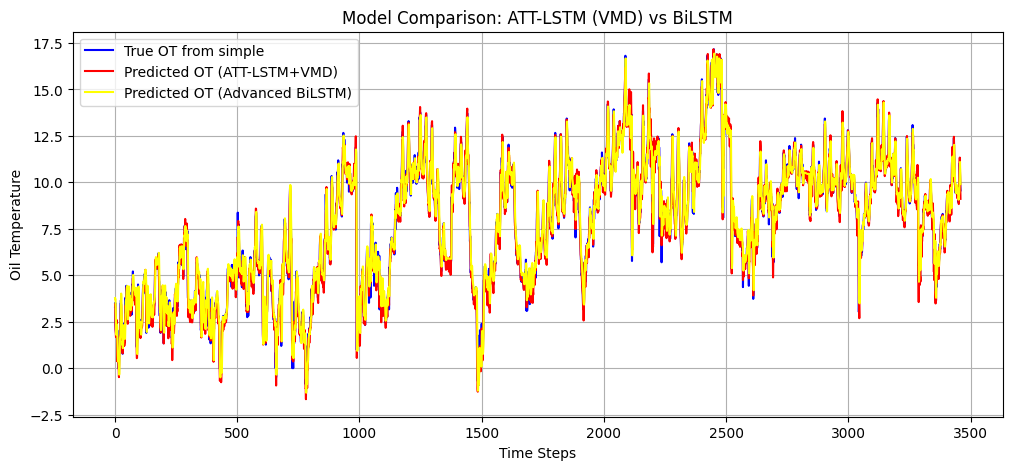

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_vmd, rmse_vmd, mae_vmd, r2_vmd = compute_metrics(y_pred_attlstm_true, y_test_simple_true)
mse_adv, rmse_adv, mae_adv, r2_adv = compute_metrics(y_pred_lstm_true, y_test_simple_true)

# Print comparison
print("📈 Model Performance Comparison")
print(f"ATT-LSTM (VMD): MSE={mse_vmd:.4f}, RMSE={rmse_vmd:.4f}, MAE={mae_vmd:.4f}, R²={r2_vmd:.4f}")
print(f"Advanced BiLSTM: MSE={mse_adv:.4f}, RMSE={rmse_adv:.4f}, MAE={mae_adv:.4f}, R²={r2_adv:.4f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT from simple', color='blue')
plt.plot(y_pred_attlstm_true, label='Predicted OT (ATT-LSTM+VMD)', color='red')
plt.plot(y_pred_lstm_true[:len(y_test_simple_true)], label='Predicted OT (Advanced BiLSTM)', color='yellow')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Model Comparison: ATT-LSTM (VMD) vs BiLSTM')
plt.legend()
plt.grid(True)
plt.show()


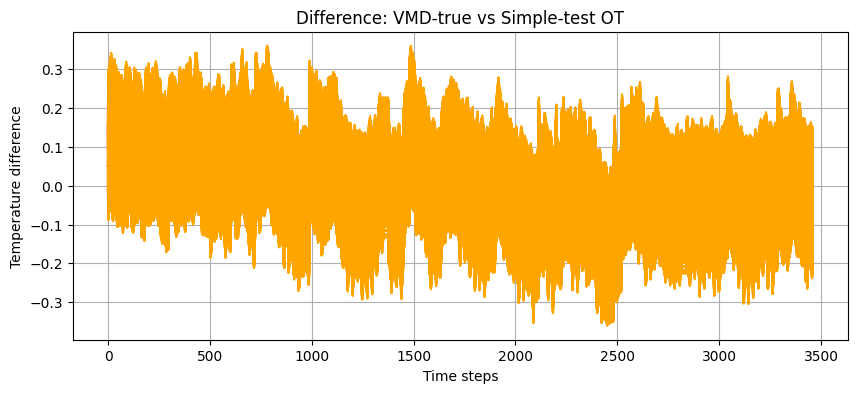

In [35]:
diff = y_test_simple_seq - y_test_vmd_seq
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: VMD-true vs Simple-test OT')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()

In [45]:
print(y_test_vmd_seq)

[[0.14746341]
 [0.15167608]
 [0.12779763]
 ...
 [0.28652145]
 [0.27667858]
 [0.27246592]]


In [46]:
print(y_test_simple_seq)

[0.14746341 0.15167608 0.12779763 ... 0.28652145 0.27667858 0.27246592]


In [47]:
print(y_test_simple_true)

[ 3.30599999  3.51699996  2.3210001  ... 10.27099991  9.77799988
  9.56700039]


In [48]:
print(y_test_vmd_true)

[[ 3.30599999]
 [ 3.51699996]
 [ 2.3210001 ]
 ...
 [10.27099991]
 [ 9.77799988]
 [ 9.56700039]]


In [41]:
np.set_printoptions()  # resets to default
for i in range(0, len(diff), 50):  # هر ۵۰ عنصر یک بار
    print(diff[i:i+50])


[[ 0.          0.00421267 -0.01966578 -0.02527602 -0.02809112 -0.01685068 -0.01545311 -0.02527602 -0.02527602 -0.04915447 -0.05196957 -0.05196957 -0.0393116  -0.05055204 -0.06600515 -0.06600515
  -0.06600515 -0.05055204 -0.03791403 -0.02527602 -0.04072913 -0.02667359  0.0028151   0.0028151   0.00702777 -0.00139757 -0.01685068 -0.01824825 -0.03230379 -0.04072913 -0.02246092 -0.05055204
  -0.02809112 -0.02948869 -0.02106335 -0.02527602 -0.02246092 -0.01824825 -0.03230379 -0.03509893 -0.02809112 -0.01263801 -0.00842534  0.00984287 -0.00700781  0.00141754  0.02248089  0.01124044
   0.01685068  0.01685068 -0.00139757 -0.00842534 -0.01685068  0.0028151   0.01545311  0.0056302   0.01966578  0.00984287 -0.00279514  0.01545311 -0.00421267  0.0056302  -0.00842534 -0.00561024
   0.0056302   0.0028151  -0.00842534  0.01124044 -0.00842534  0.          0.02387845  0.01405555  0.01545311  0.03793399  0.01966578  0.01966578  0.01263801  0.01826822  0.01966578  0.00984287
   0.01263801  0.01826822  0.0

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

